Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,1 hour 43 mins
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.39.0.99999
H2O_cluster_version_age:,1 hour and 47 minutes
H2O_cluster_name:,tomasfryda
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,892 Mb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%


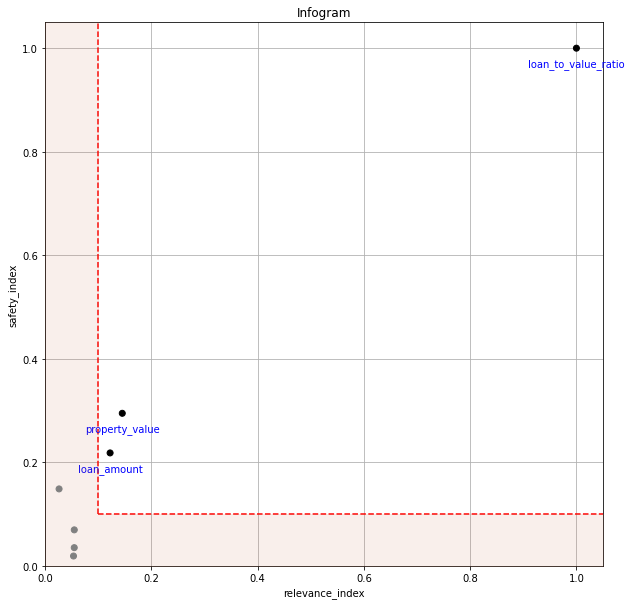

column,admissible,admissible_index,relevance_index,safety_index,cmi_raw
loan_to_value_ratio,1,1,1,1,0.0941406
property_value,1,0.232405,0.145431,0.294744,0.0277474
loan_amount,1,0.176956,0.122526,0.218206,0.0205421
income,0,0.106802,0.0265004,0.148697,0.0139985
intro_rate_period,0,0.0627864,0.0551325,0.0696038,0.00655254
loan_term,0,0.046236,0.0550699,0.0352539,0.00331882
debt_to_income_ratio,0,0.0402932,0.0537012,0.0190596,0.00179428


In [1]:
import h2o
from h2o.automl import *
from h2o.estimators.infogram import H2OInfogram

h2o.connect()

# Import HDMA dataset
f = "https://erin-data.s3.amazonaws.com/admissible/data/hmda_lar_2018_sample.csv"
col_types = {'high_priced': "enum"}
df = h2o.import_file(path=f, col_types=col_types)

# We will split the data so that we can test/compare performance
# of admissible vs non-admissible models later
train, test = df.split_frame(ratios=[0.8], seed=1)

# Response column and predictor columns
y = "high_priced"
x =  ["loan_amount",
      "loan_to_value_ratio",
      "loan_term",
      "intro_rate_period",
      "property_value",
      "income",
      "debt_to_income_ratio"]

# Fairness related information
protected_columns = ["derived_race", "derived_sex"]
reference = ["White", "Male"]
favorable_class = "0"

# Infogram
ig = H2OInfogram(protected_columns=protected_columns)
ig.train(y=y, x=x, training_frame=train)
ig.plot()

# Admissible score frame
asf = ig.get_admissible_score_frame()
asf

In [2]:
# Train models on different subsets of features selected by infogram
da = ig.train_subset_models(H2OAutoML, y, train, test, protected_columns, reference, favorable_class, max_models=10, seed=1)
da

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,num_of_features,var,corrected_var,air_min,air_mean,air_median,air_max,cair,significant_air_min,significant_air_mean,significant_air_median,significant_air_max,p.value_min,p.value_mean,p.value_median,p.value_max
StackedEnsemble_AllModels_1_AutoML_35_20221208_180609,0.85075,0.271505,0.47292,0.252432,0.285302,0.0813975,22582,0.029297,StackedEnsemble,7,0.00529065,0.00529065,0.765944,0.97949,1.00099,1.11694,0.990789,0.765944,0.925672,0.860042,1.11694,1.10185e-39,0.432293,0.455291,1
StackedEnsemble_BestOfFamily_1_AutoML_35_20221208_180609,0.849025,0.272757,0.46821,0.259026,0.285825,0.081696,24597,0.018246,StackedEnsemble,7,0.00635303,0.00635303,0.733577,0.97663,1.00147,1.13548,0.990452,0.733577,0.914688,0.850797,1.13548,1.62109e-45,0.478835,0.497316,1
StackedEnsemble_AllModels_1_AutoML_34_20221208_180217,0.848842,0.272335,0.474325,0.250286,0.285504,0.0815126,22722,0.022641,StackedEnsemble,6,0.00594179,0.00594179,0.745615,0.979764,1.00394,1.12859,0.988746,0.745615,0.907798,0.844812,1.12859,2.36648e-44,0.494873,0.57807,1
StackedEnsemble_BestOfFamily_1_AutoML_34_20221208_180217,0.848441,0.272818,0.472626,0.251506,0.285672,0.0816086,21627,0.018372,StackedEnsemble,6,0.00511355,0.00511355,0.737653,0.967604,1.00079,1.12827,0.988942,0.737653,0.904503,0.842256,1.12827,1.70464e-42,0.463614,0.586117,1
XGBoost_3_AutoML_35_20221208_180609,0.847691,0.273393,0.46894,0.263194,0.286006,0.0817993,3908,0.002935,XGBoost,7,0.00593699,0.00593699,0.761509,0.977403,1.00216,1.11262,0.990231,0.761509,0.921565,0.8482,1.11262,1.65569e-42,0.391109,0.532732,1
XGBoost_3_AutoML_34_20221208_180217,0.846846,0.27358,0.47131,0.247711,0.28601,0.0818018,3355,0.002503,XGBoost,6,0.0062938,0.0062938,0.713172,0.972281,1.00066,1.15728,0.988252,0.713172,0.897472,0.845538,1.11881,9.8231e-44,0.437499,0.392908,1
XGBoost_2_AutoML_35_20221208_180609,0.845576,0.275135,0.461429,0.249549,0.28729,0.0825357,3830,0.00315,XGBoost,7,0.00535889,0.00535889,0.775897,0.980804,1.00512,1.10141,0.989421,0.775897,0.937747,0.955149,1.10141,2.16778e-40,0.421098,0.560022,1
StackedEnsemble_AllModels_1_AutoML_33_20221208_175909,0.844664,0.275223,0.463859,0.255883,0.28689,0.0823061,19782,0.027434,StackedEnsemble,5,0.00572474,0.00572474,0.736285,0.973376,1.00143,1.12269,0.988634,0.736285,0.910441,0.842579,1.12269,1.10785e-46,0.432894,0.455854,1
StackedEnsemble_BestOfFamily_1_AutoML_33_20221208_175909,0.843951,0.275925,0.458906,0.256599,0.287187,0.0824762,18709,0.016466,StackedEnsemble,5,0.00548182,0.00548182,0.759505,0.976403,1.0103,1.11621,0.989056,0.759505,0.910667,0.850645,1.11621,2.56641e-42,0.4037,0.310036,1
GBM_4_AutoML_34_20221208_180217,0.843922,0.276234,0.45389,0.25621,0.28764,0.0827368,2254,0.007186,GBM,6,0.00581139,0.00581139,0.796127,0.979782,1.00007,1.11196,0.992499,0.796127,0.953822,0.961102,1.11196,3.97915e-33,0.481223,0.685476,1


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo,num_of_features,var,corrected_var,air_min,air_mean,air_median,air_max,cair,significant_air_min,significant_air_mean,significant_air_median,significant_air_max,p.value_min,p.value_mean,p.value_median,p.value_max
StackedEnsemble_AllModels_1_AutoML_35_20221208_180609,0.85075,0.271505,0.47292,0.252432,0.285302,0.0813975,22582,0.029297,StackedEnsemble,7,0.00529065,0.00529065,0.765944,0.97949,1.00099,1.11694,0.990789,0.765944,0.925672,0.860042,1.11694,1.10185e-39,0.432293,0.455291,1
XGBoost_2_AutoML_35_20221208_180609,0.845576,0.275135,0.461429,0.249549,0.28729,0.0825357,3830,0.00315,XGBoost,7,0.00535889,0.00535889,0.775897,0.980804,1.00512,1.10141,0.989421,0.775897,0.937747,0.955149,1.10141,2.16778e-40,0.421098,0.560022,1
GBM_4_AutoML_34_20221208_180217,0.843922,0.276234,0.45389,0.25621,0.28764,0.0827368,2254,0.007186,GBM,6,0.00581139,0.00581139,0.796127,0.979782,1.00007,1.11196,0.992499,0.796127,0.953822,0.961102,1.11196,3.97915e-33,0.481223,0.685476,1
XGBoost_1_AutoML_35_20221208_180609,0.843448,0.277989,0.454395,0.254712,0.289126,0.0835941,5229,0.003437,XGBoost,7,0.00351762,0.00351762,0.799487,0.984814,1.00626,1.09772,0.990846,0.799487,0.929281,0.880262,1.09772,2.0444e-34,0.455747,0.516162,1
XGBoost_1_AutoML_33_20221208_175909,0.837357,0.28159,0.44418,0.254342,0.29065,0.0844775,4686,0.002913,XGBoost,5,0.00485077,0.00485077,0.807207,0.975157,1.00267,1.12213,0.99275,0.807207,0.937024,0.878041,1.09295,5.95856e-31,0.331811,0.277824,1


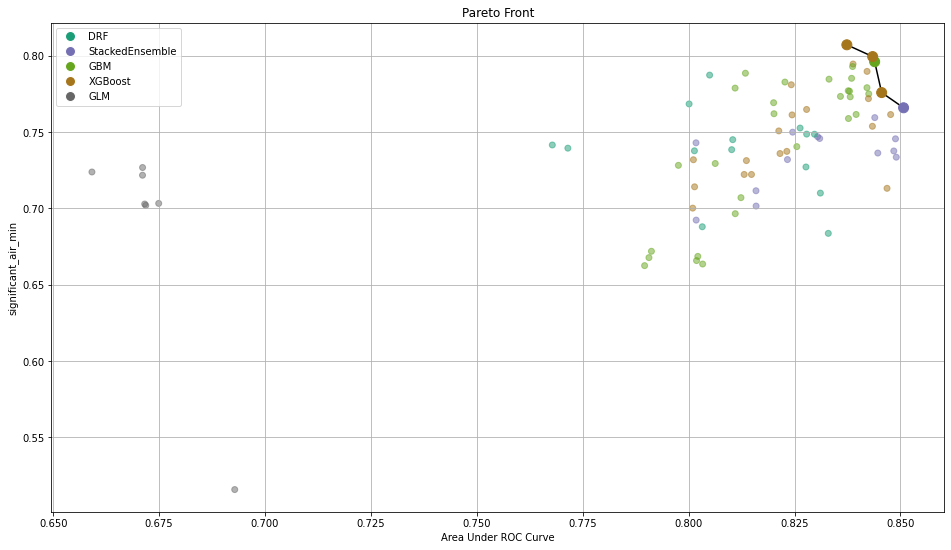

In [3]:
# Select the best models with respect to AUC and AIR
h2o.explanation.pareto_front(da, x_metric="auc", y_metric="significant_air_min", optimum="top right", color_col="algo")

In [4]:
# Pick a model that satisfies the four fifths rule
potentially_fair_model = h2o.get_model(da[da["significant_air_min"] > 0.8, "model_id"][0, 0])

# Overview for model XGBoost_1_AutoML_33_20221208_175909

> The following table shows fairness metrics for intersections determined using the protected_columns. Apart from the fairness metrics, there is a p-value from Fisher's exact test or G-test (depends on the size of the intersections) for hypothesis that being selected (positive response) is independent to being in the reference group or a particular protected group.

After the table there are two kinds of plot. The first kind starts with AIR prefix which stands for Adverse Impact Ratio. These plots show values relative to the reference group and also show two dashed lines corresponding to 0.8 and 1.25 (the four-fifths rule). 
 The second kind is showing the absolute value of given metrics. The reference group is shown by using a different colored bar.

derived_race,derived_sex,AIR_auc,AIR_aucpr,AIR_f1,AIR_selectedRatio,auc,aucpr,f1,p.value,selectedRatio,total
2 or more minority races,Female,1.02182,1.00685,0.967116,0.95515,0.857143,0.979769,0.888889,0.72182,0.8125,16
American Indian or Alaska Native,Female,0.90449,0.974675,0.897605,0.852864,0.758721,0.948459,0.825,0.0179482,0.72549,51
Asian,Female,1.09238,1.01225,1.04543,1.05406,0.916327,0.985018,0.960864,0.00869533,0.896635,416
Black or African American,Female,0.896947,0.921109,0.888481,0.807207,0.752393,0.896334,0.816614,5.95856e-31,0.686652,884
Native Hawaiian or Other Pacific Islander,Female,1.10847,1.01681,1.03361,1.12213,0.929825,0.989465,0.95,0.236259,0.954545,22
Race Not Available,Female,0.939426,0.99119,1.00149,1.02115,0.788027,0.964529,0.920482,0.318718,0.868644,472
White,Female,0.994853,0.998371,1.00071,1.00535,0.834521,0.971517,0.91977,0.477256,0.855198,5290
2 or more minority races,Male,0.638638,0.921521,0.92062,0.881677,0.535714,0.896734,0.846154,0.283053,0.75,16
American Indian or Alaska Native,Male,0.972198,0.980643,0.982094,0.950828,0.815517,0.954266,0.902655,0.309009,0.808824,68
Asian,Male,1.13647,1.02467,1.05459,1.09295,0.953313,0.997109,0.969287,8.73843e-12,0.929724,868


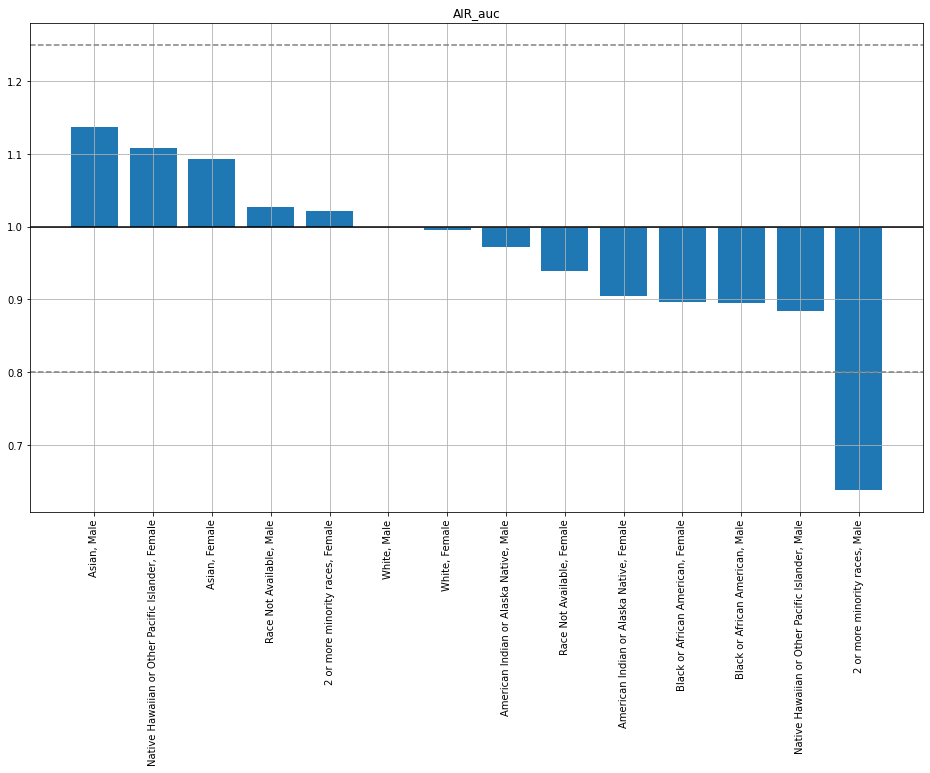

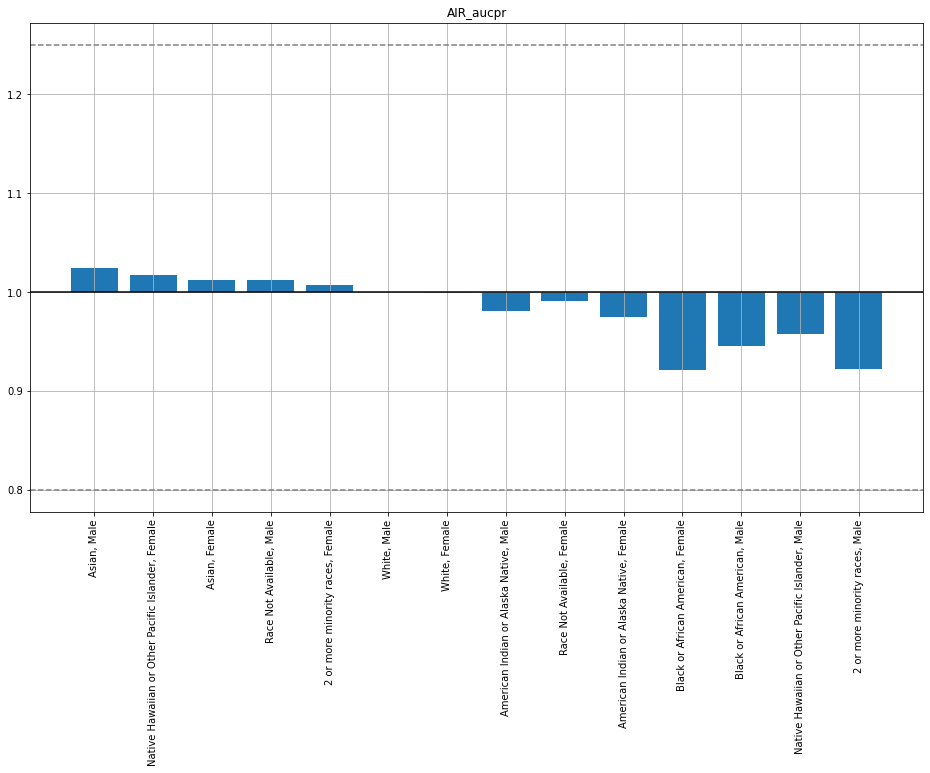

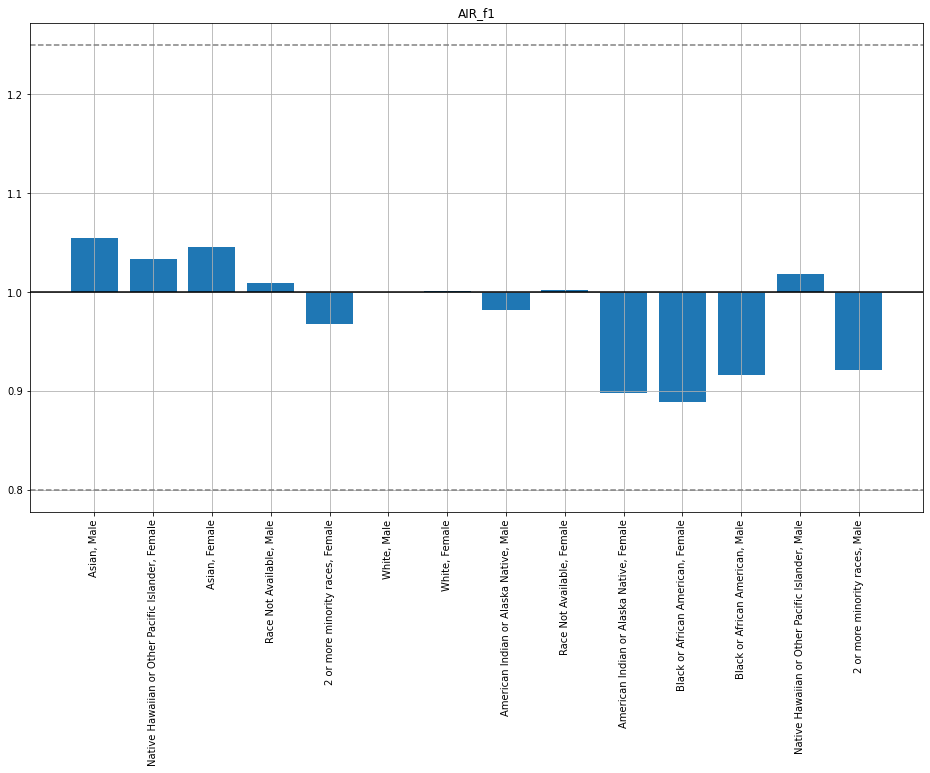

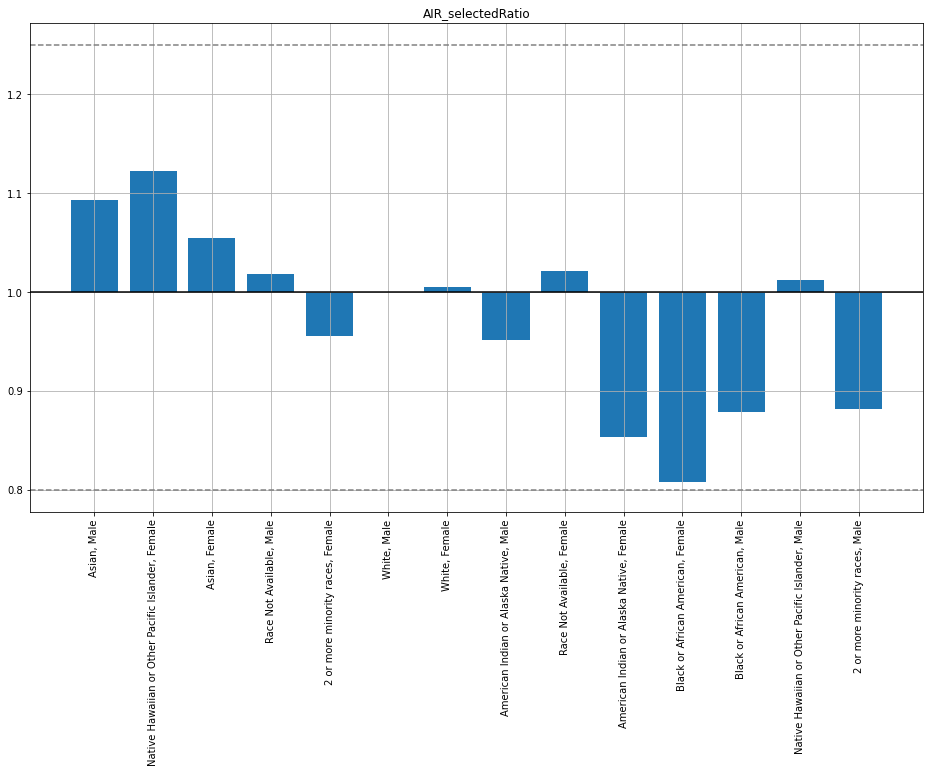

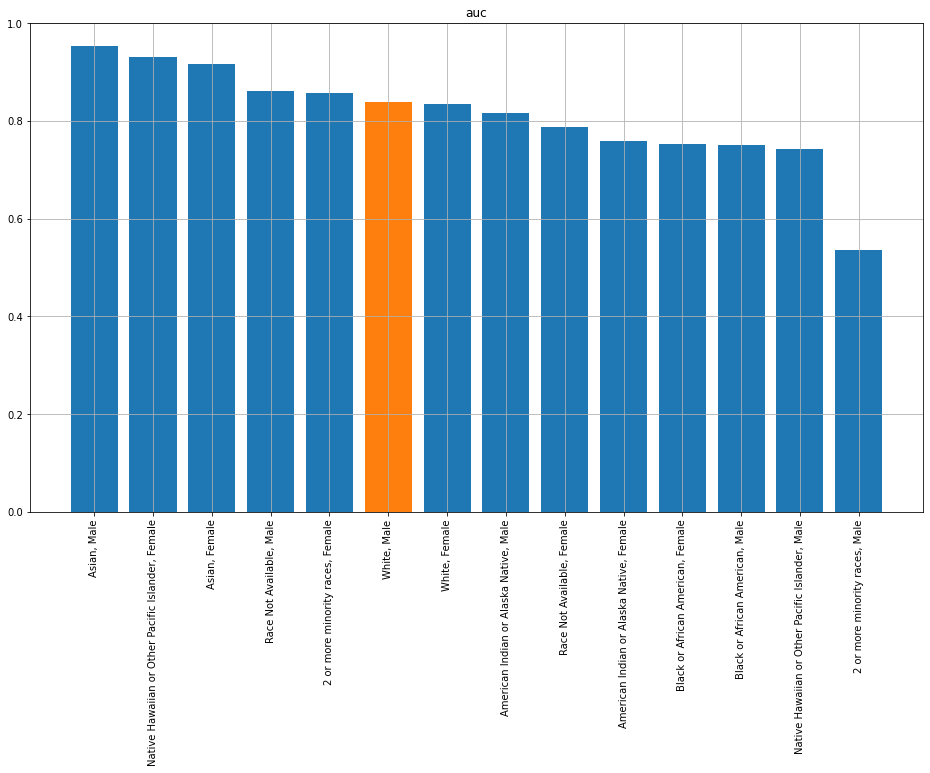

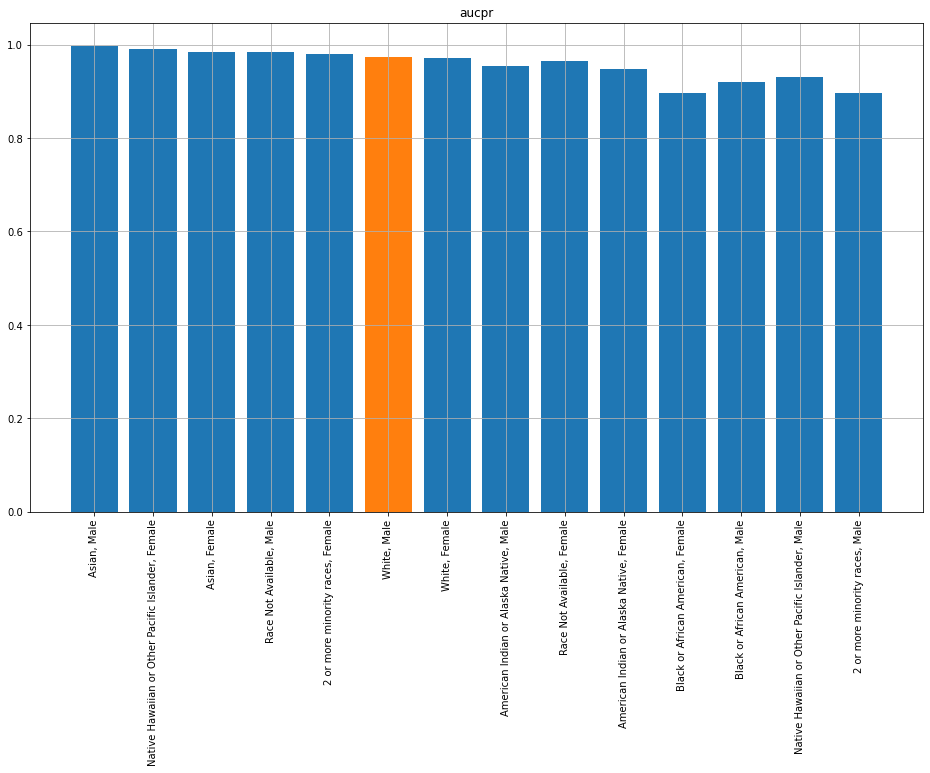

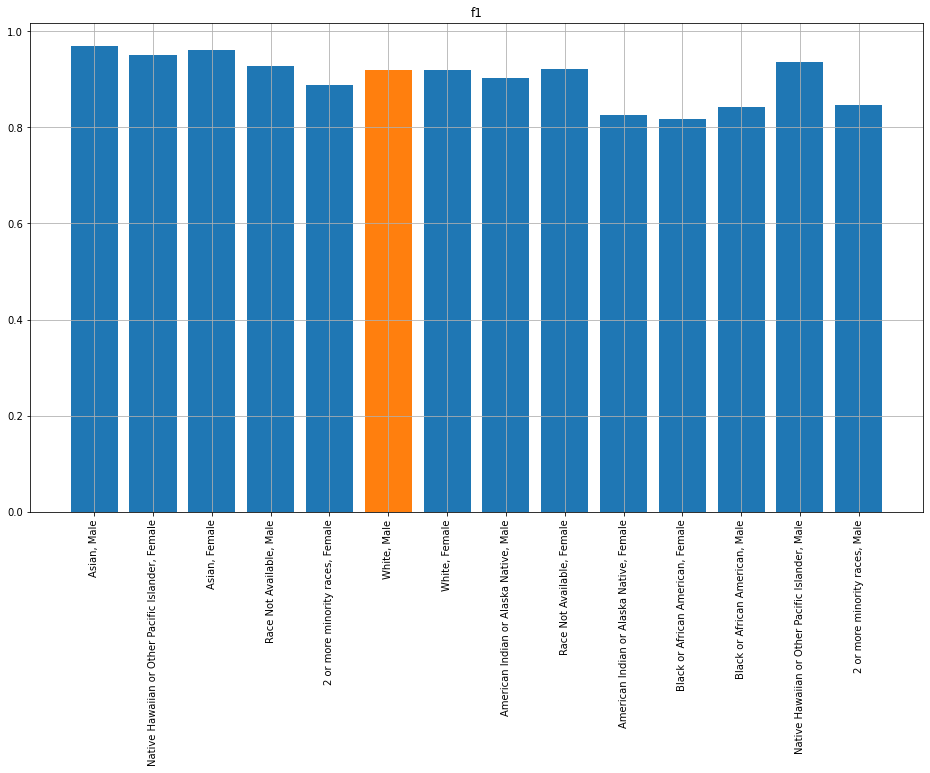

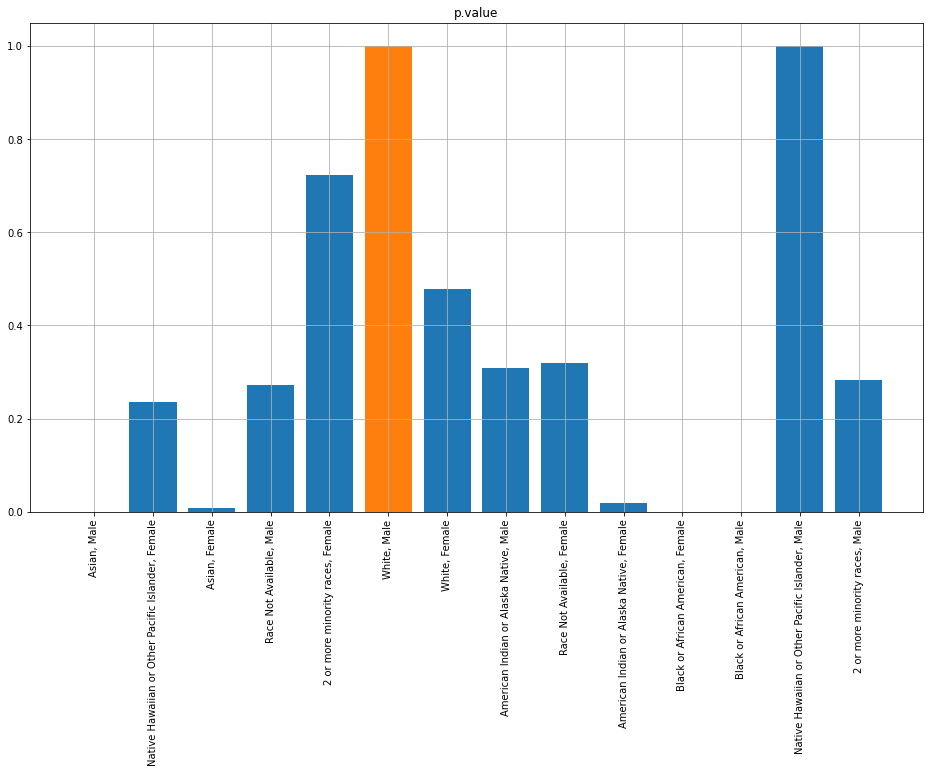

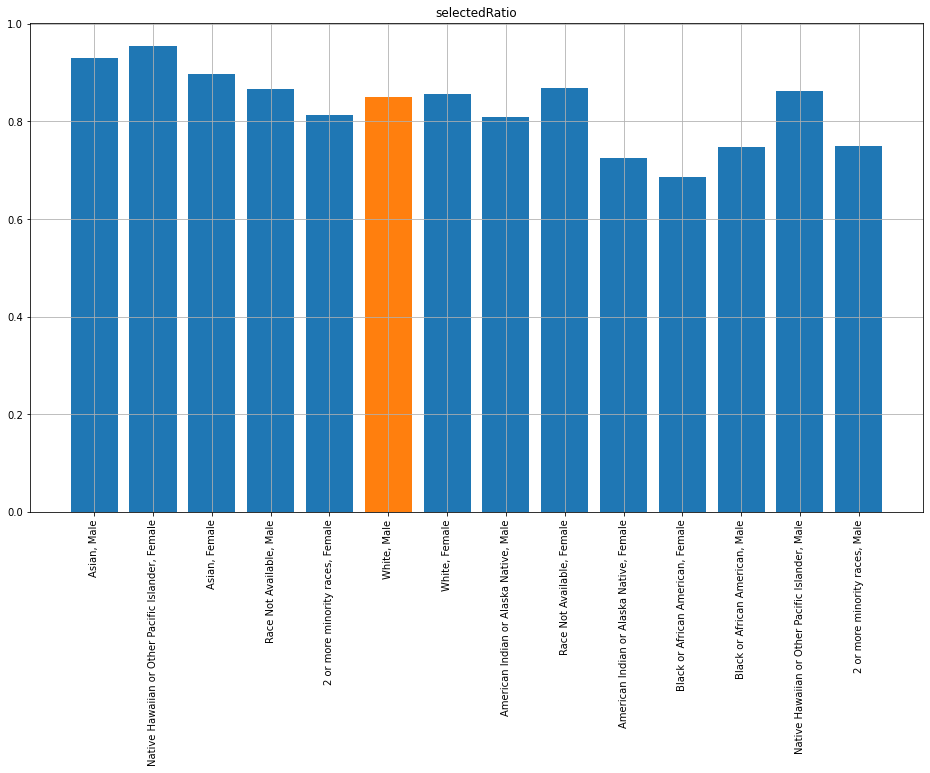

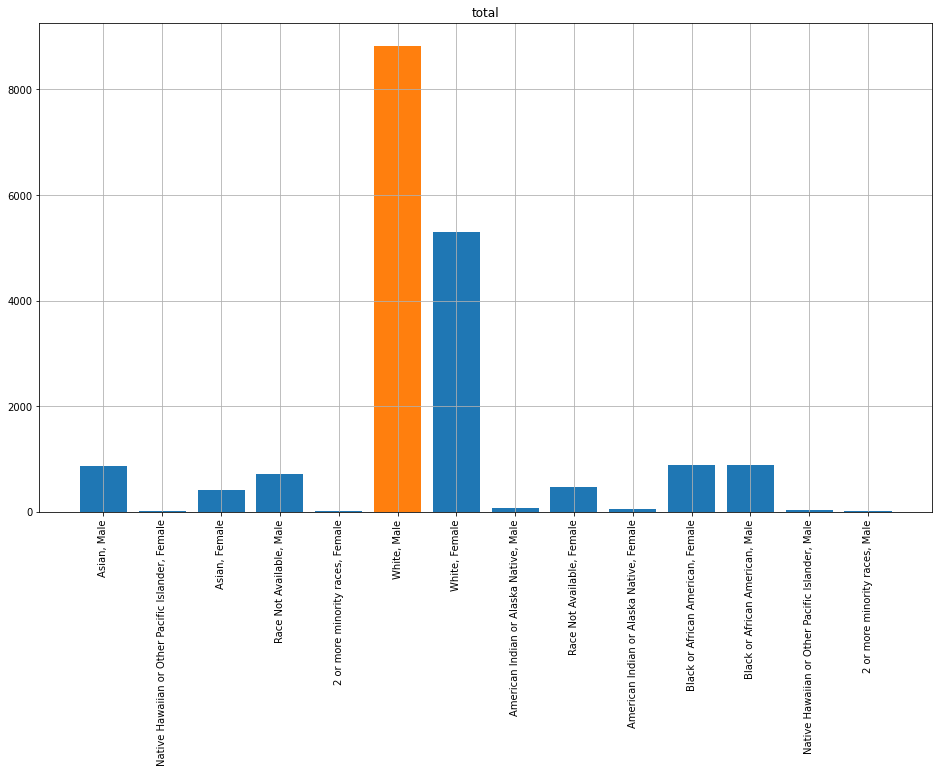

# ROC

> The following plot shows a Receiver Operating Characteristic (ROC) for each intersection. This plot could be used for selecting different threshold of the classifier to make it more fair in some sense this is described in, e.g., HARDT, Moritz, PRICE, Eric and SREBRO, Nathan, 2016. Equality of Opportunity in Supervised Learning. arXiv:1610.02413.

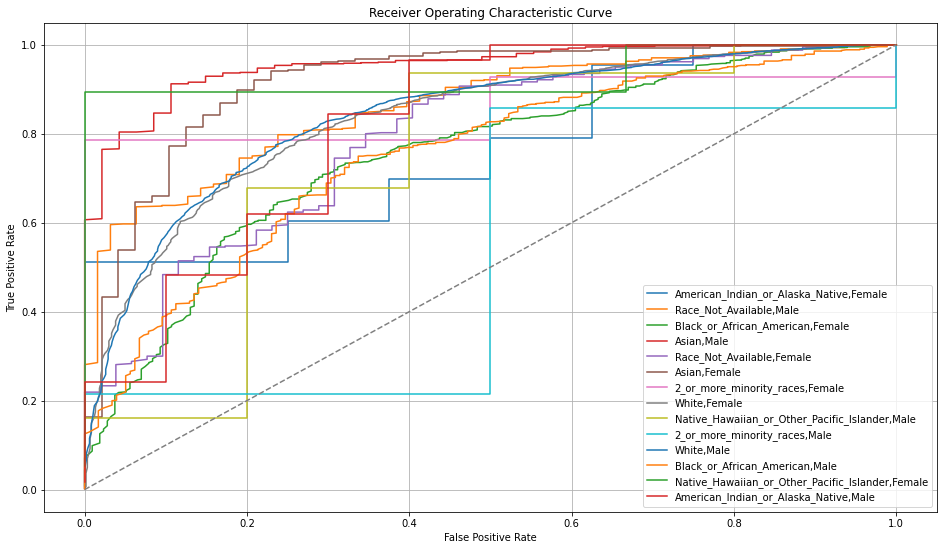

# Precision-Recall Curve

> The following plot shows a Precision-Recall Curve for each intersection.

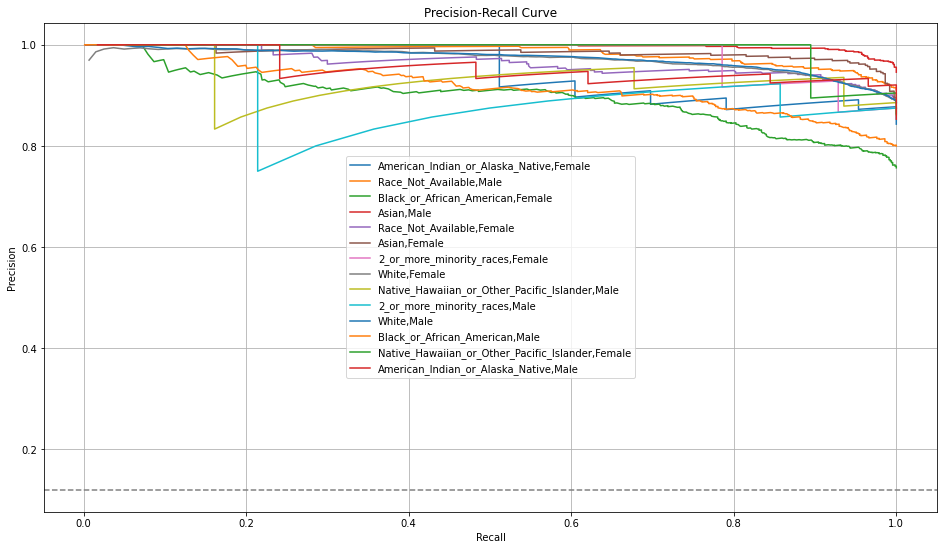

# Permutation Variable Importance

> Permutation variable importance is obtained by measuring the distance between prediction errors before and after a feature is permuted; only one feature at a time is permuted.

Variable,Relative Importance,Scaled Importance,Percentage
loan_to_value_ratio,0.2429555,1.0,0.6288179
property_value,0.0581869,0.2394962,0.1505995
loan_amount,0.0444545,0.1829738,0.1150572
intro_rate_period,0.0258223,0.1062841,0.0668333
income,0.0149494,0.0615314,0.0386920


# Partial Dependence Plots for Individual Protected Groups

> The following plots show partial dependence for each intersection separately. This plot can be used to see how the membership to a particular intersection influences the dependence on a given feature.

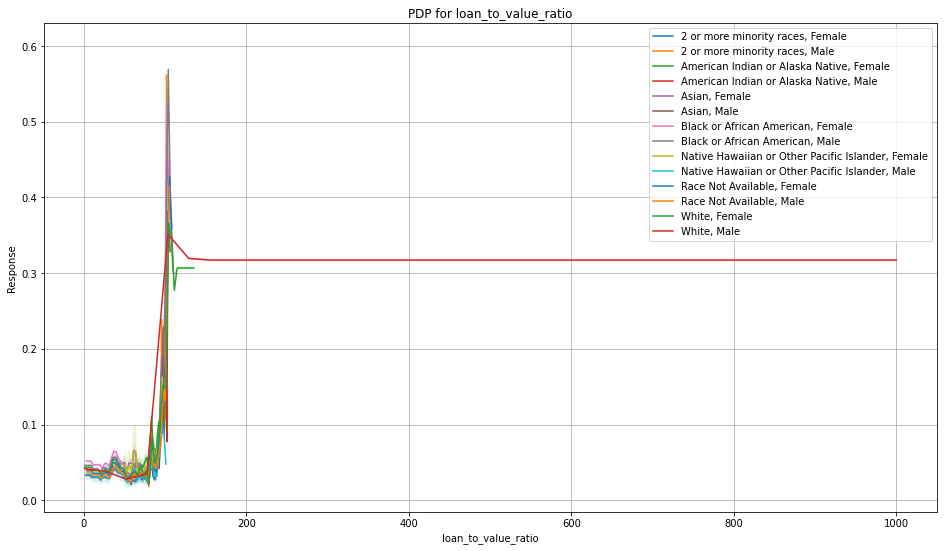

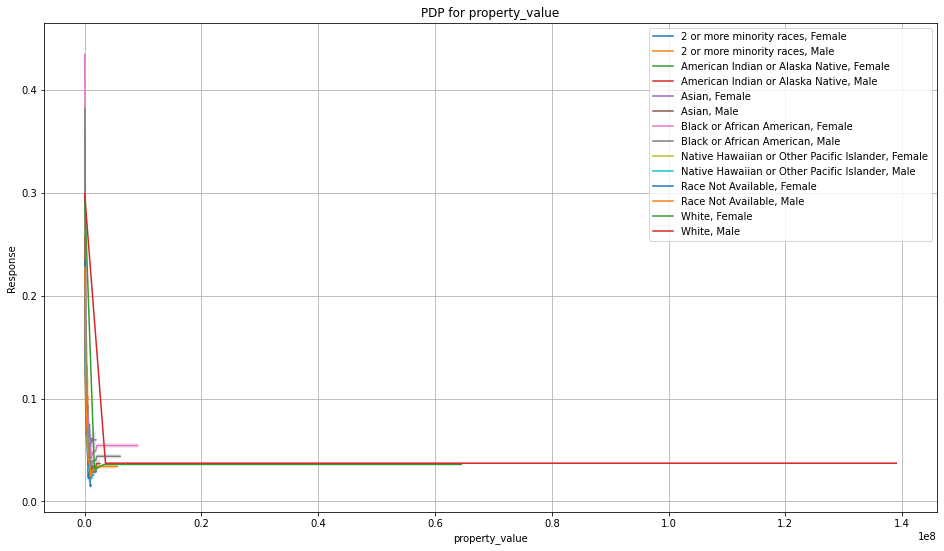

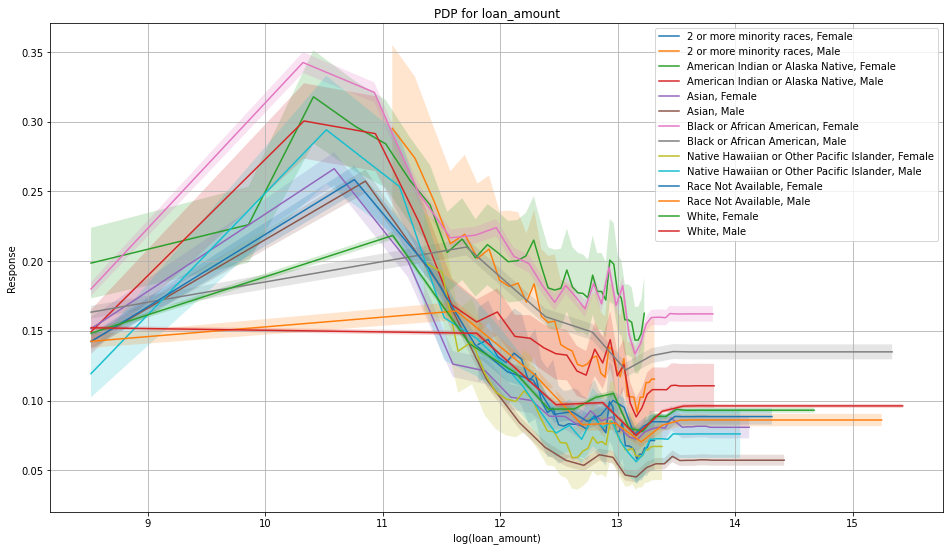

/Users/tomasfryda/sources/h2o-3/h2o-py/h2o/model/extensions/fairness.py:133: RuntimeWarning: All-NaN axis encountered
  maxes.append(np.nanmax(pd[column.lower()]))


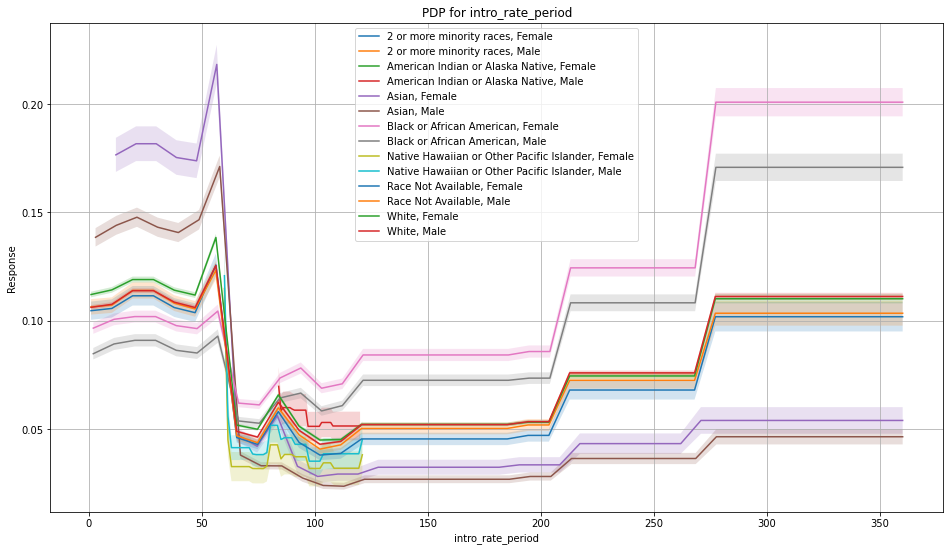

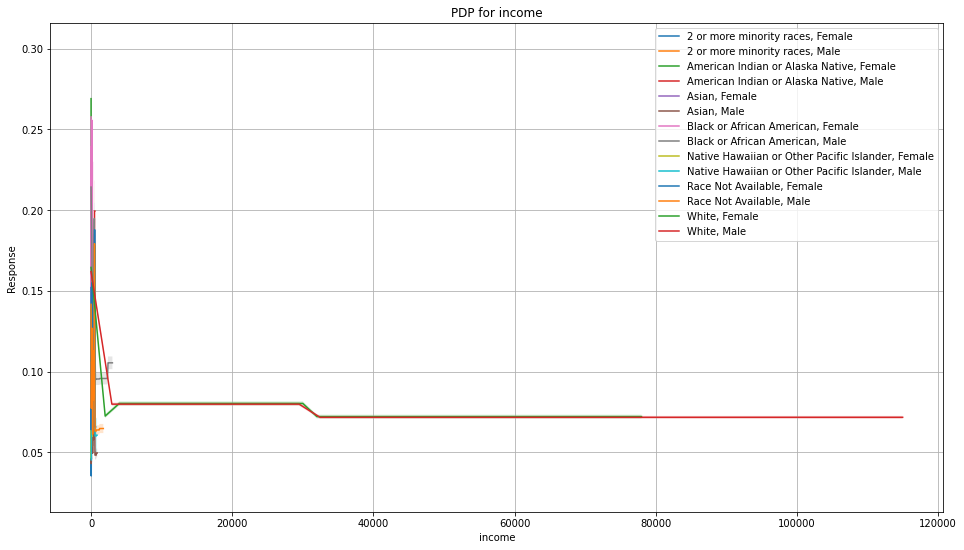

# SHAP for Individual Protected Groups

> The following plots show SHAP contributions for individual intersections and one feature at a time.This plot can be used to see how the membership to a particular intersection influences the dependence on a given feature.

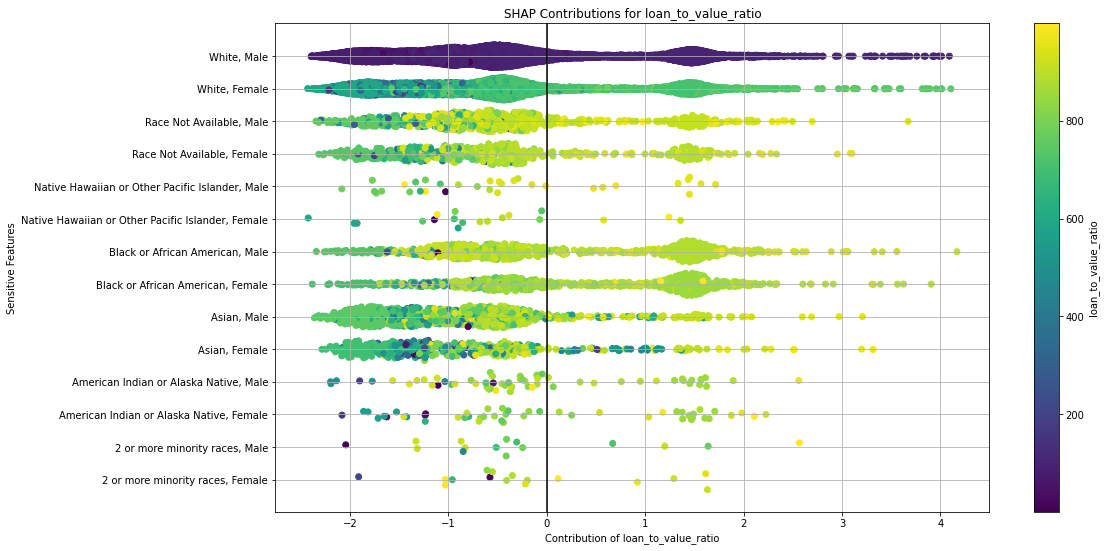

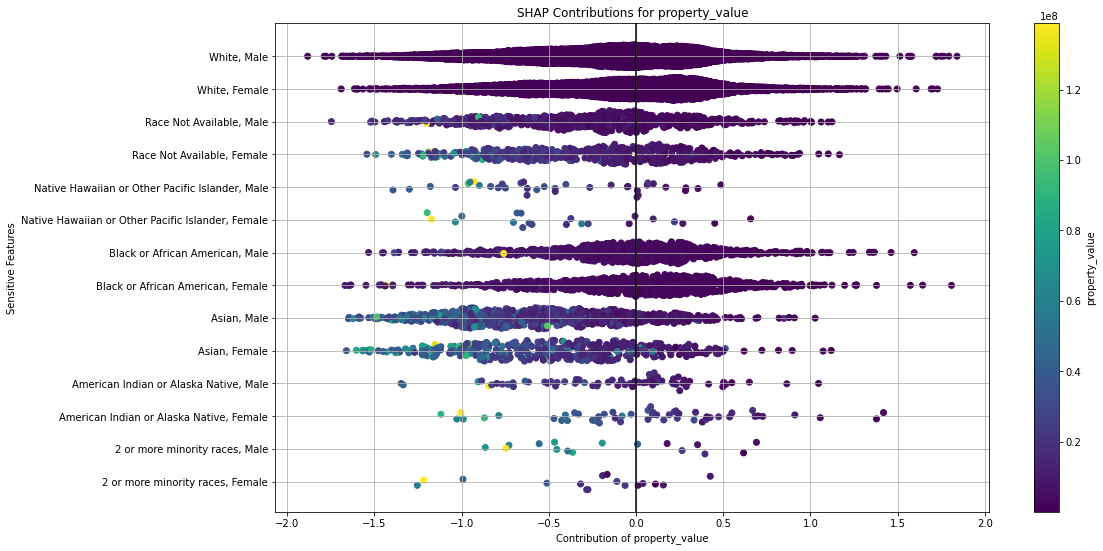

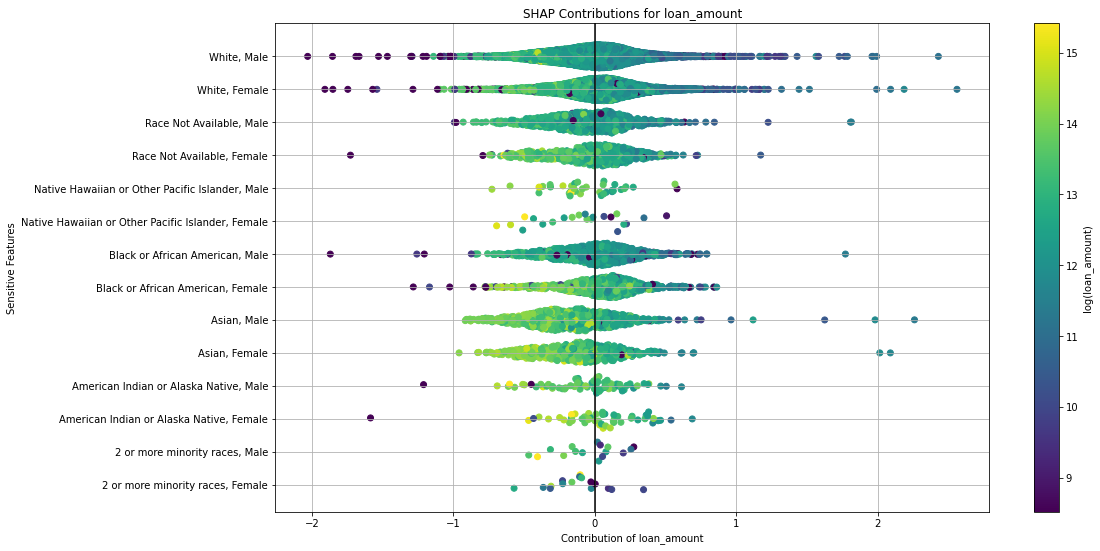

/Users/tomasfryda/sources/h2o-3/h2o-py/h2o/model/extensions/fairness.py:356: RuntimeWarning: All-NaN slice encountered
  maxes.append(np.nanmax(vals))


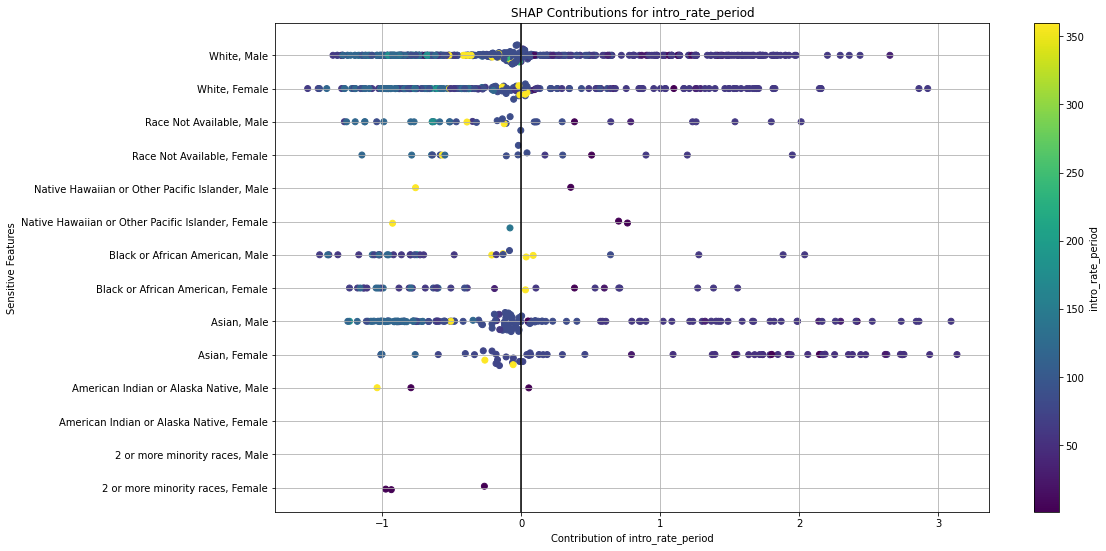

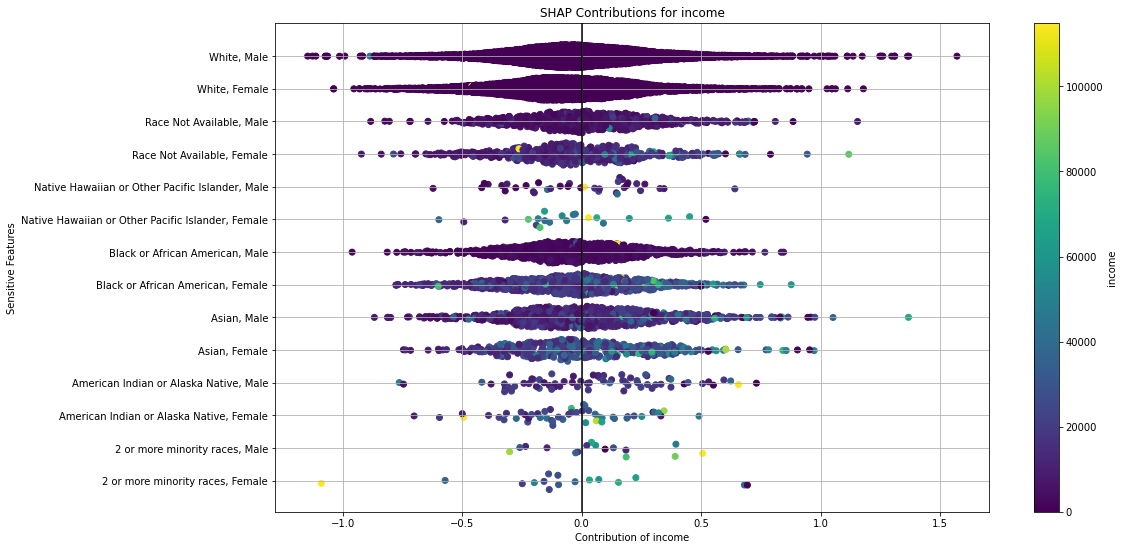

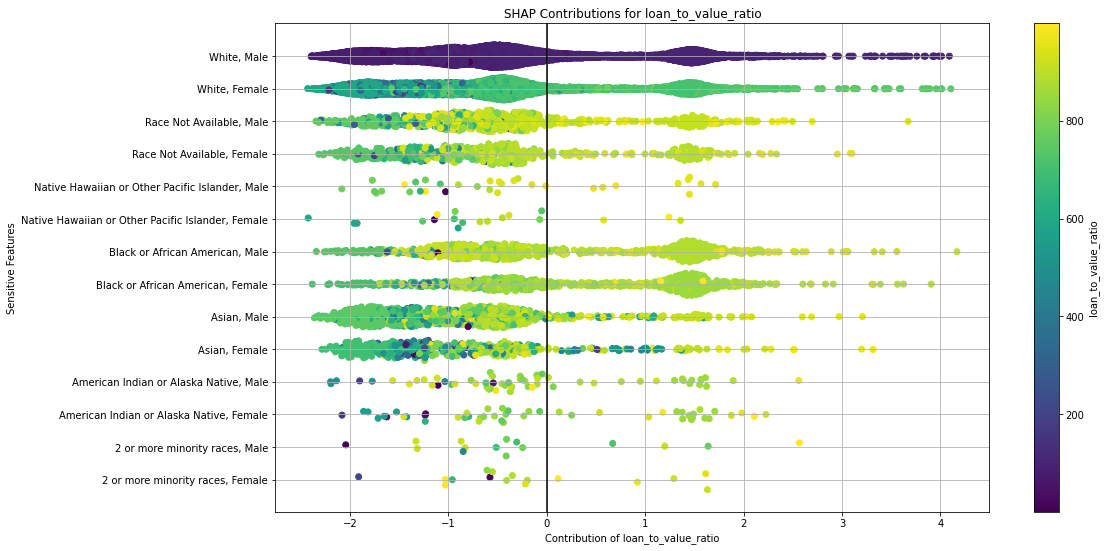

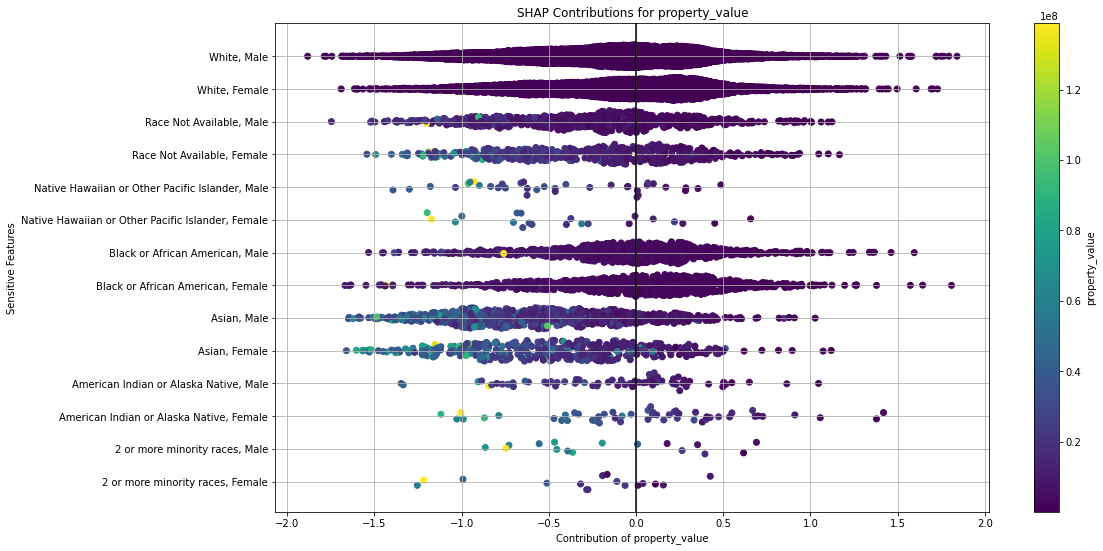

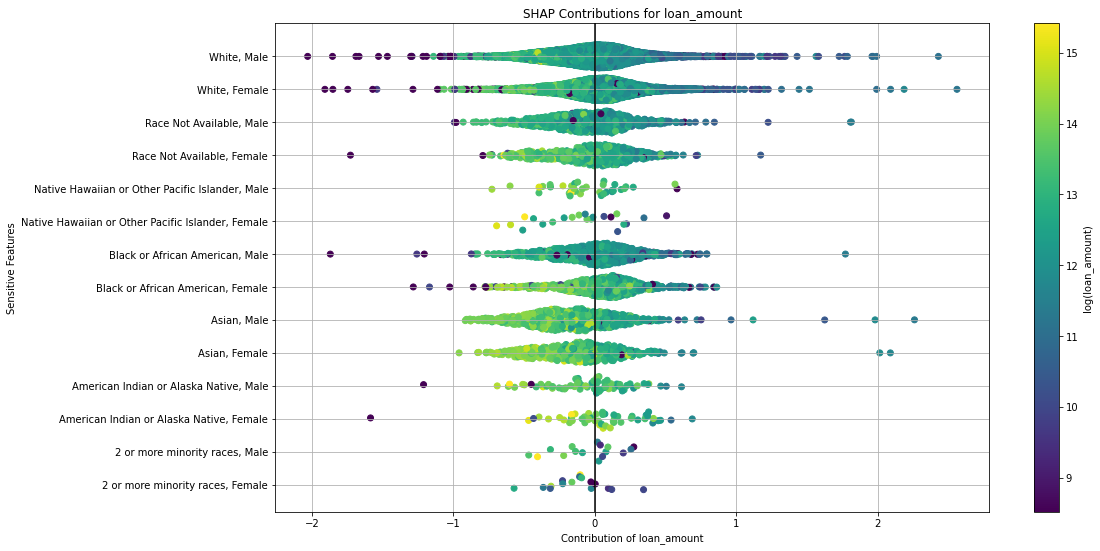

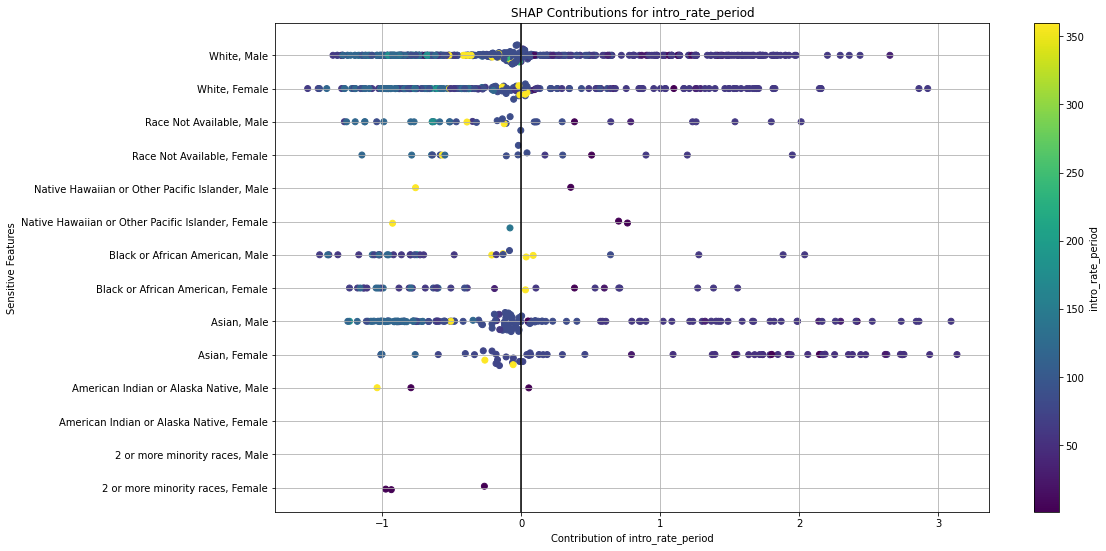

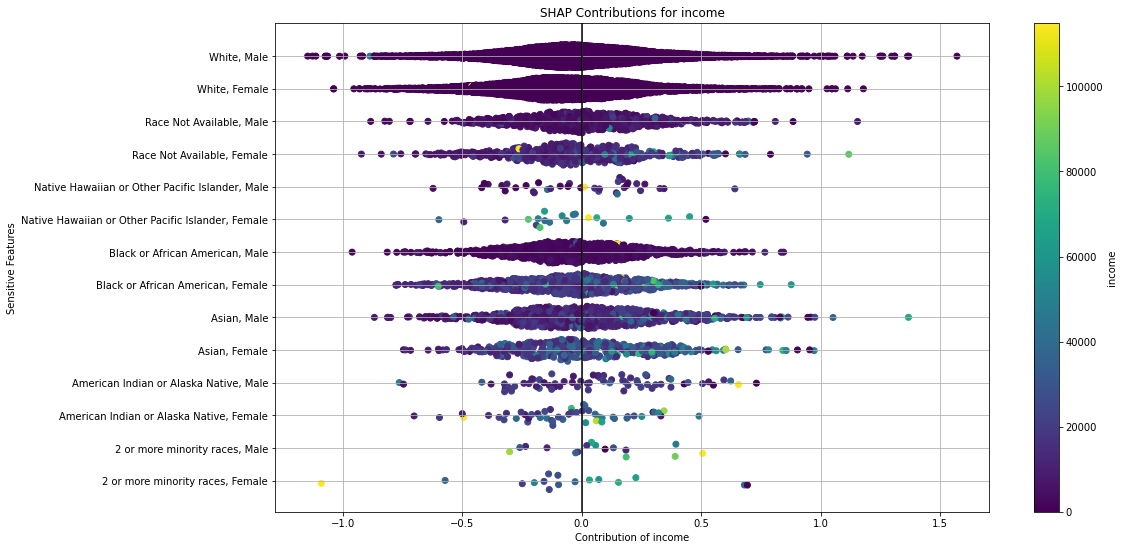

In [5]:
# Inspect the model
potentially_fair_model.inspect_model_fairness(test, protected_columns, reference, favorable_class);